In [1]:
import requests
from pyjstat import pyjstat
import pandas as pd

# API endpoint
url = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/HPA02/JSON-stat/2.0/en"

# Fetch data
response = requests.get(url)
response.raise_for_status()  # Raise error if request failed

# Parse JSON-stat into a DataFrame
dataset = pyjstat.Dataset.read(response.text)
df = dataset.write('dataframe')

print(df.head())


         Statistic  Year        County        Dwelling Status  \
0  Volume of Sales  2010  All Counties  All Dwelling Statuses   
1  Volume of Sales  2010  All Counties  All Dwelling Statuses   
2  Volume of Sales  2010  All Counties  All Dwelling Statuses   
3  Volume of Sales  2010  All Counties  All Dwelling Statuses   
4  Volume of Sales  2010  All Counties  All Dwelling Statuses   

  Stamp Duty Event          Type of Buyer    Type of Sale    value  
0          Filings        All Buyer Types  All Sale Types  28618.0  
1          Filings        All Buyer Types          Market  20076.0  
2          Filings        All Buyer Types      Non-Market   8542.0  
3          Filings  Household Buyer - All  All Sale Types  27643.0  
4          Filings  Household Buyer - All          Market  19302.0  


In [2]:
df.describe()
df.head()

,Statistic,Year,County,Dwelling Status,Stamp Duty Event,Type of Buyer,Type of Sale,value
0,Volume of Sales,2010,All Counties,All Dwelling Statuses,Filings,All Buyer Types,All Sale Types,28618.0
1,Volume of Sales,2010,All Counties,All Dwelling Statuses,Filings,All Buyer Types,Market,20076.0
2,Volume of Sales,2010,All Counties,All Dwelling Statuses,Filings,All Buyer Types,Non-Market,8542.0
3,Volume of Sales,2010,All Counties,All Dwelling Statuses,Filings,Household Buyer - All,All Sale Types,27643.0
4,Volume of Sales,2010,All Counties,All Dwelling Statuses,Filings,Household Buyer - All,Market,19302.0


In [3]:
def show_first_time_buyers(df, n=10):
    """
    Display rows where Buyer type == 'First-Time Buyer'

    Parameters:
        df (pd.DataFrame): The CSO HPA02 dataframe
        n (int): Number of rows to display (default=10)
    """
    if 'Buyer type' not in df.columns:
        print("❌ Column 'Buyer type' not found in dataframe.")
        print(f"Available columns: {list(df.columns)}")
        return
    
    ftb_df = df[df['Buyer type'].str.strip().str.lower() == 'first-time buyer']
    
    if ftb_df.empty:
        print("⚠️ No rows found for Buyer type == 'First-Time Buyer'")
    else:
        display(ftb_df.head(n))
        print(f"✅ Showing {min(n, len(ftb_df))} of {len(ftb_df)} rows where Buyer type == 'First-Time Buyer'")
    
    return ftb_df
ftb_df = show_first_time_buyers(df, n=10)

❌ Column 'Buyer type' not found in dataframe.
Available columns: ['Statistic', 'Year', 'County', 'Dwelling Status', 'Stamp Duty Event', 'Type of Buyer', 'Type of Sale', 'value']


In [4]:
# --- STEP 1: Install dependencies (run once) ---
# !pip install requests pyjstat ydata-profiling --quiet
# !pip install --upgrade pip setuptools wheel
# !pip install ipywidgets

# --- STEP 2: Import libraries ---
import requests
import pandas as pd
from pyjstat import pyjstat
from ydata_profiling import ProfileReport
import pkg_resources

# --- STEP 3: Fetch dataset from CSO API ---
url = "https://ws.cso.ie/public/api.restful/PxStat.Data.Cube_API.ReadDataset/HPA02/JSON-stat/2.0/en"

response = requests.get(url)
response.raise_for_status()  # Check for errors

dataset = pyjstat.Dataset.read(response.text)
df = dataset.write('dataframe')

# --- STEP 4: Clean column names (optional) ---
df.columns = df.columns.str.replace(' ', '_').str.lower()
df = df[df['value'] > 0]
# remove any county that says 'all_counties'
df = df[df['county'] != 'All Counties']

# Filter for Mean and Median Sale Price
df_mean = df[(df['statistic'] == 'Mean Sale Price') & (df['type_of_buyer'] == 'Household Buyer - First-Time Buyer Owner-Occupier')]
df_median = df[(df['statistic'] == 'Median Price') & (df['type_of_buyer'] == 'Household Buyer - First-Time Buyer Owner-Occupier')]

# Rename for clarity
df_mean = df_mean.rename(columns={'value': 'mean_price'})
df_median = df_median.rename(columns={'value': 'median_price'})

# Merge on region, dwelling, and quarter
df_prices = pd.merge(
    df_mean[['county', 'dwelling_status', 'year', 'mean_price']],
    df_median[['county', 'dwelling_status', 'year', 'median_price']],
    on=['county', 'dwelling_status', 'year'],
    how='inner'
)

# Add derived features
df_prices['price_gap'] = df_prices['mean_price'] - df_prices['median_price']
df_prices['gap_ratio'] = df_prices['mean_price'] / df_prices['median_price']
# 
# # --- STEP 5: Display a quick feature summary ---
# feature_summary = pd.DataFrame({
#     'Data_Type': df.dtypes,
#     'Unique_Values': df.nunique(),
#     'Missing_Values': df.isnull().sum(),
#     'Sample_Value': [df[col].dropna().iloc[0] for col in df.columns]
# })
# display(feature_summary)

# # --- STEP 6: Show first few rows for context ---
# display(df.head())

# # --- STEP 7: Generate interactive profiling report ---
# profile = ProfileReport(
#     df,
#     title="CSO HPA02 - Residential Property Transactions Overview",
#     explorative=True,
#     minimal=True  # Faster rendering for large datasets
# )

# # Display the report inline in Jupyter
# profile.to_notebook_iframe()
df_prices.head()
# show county = 'Dublin' and year = '2024'
df_prices[(df_prices['county'] == 'Dublin') & (df_prices['year'] == '2024')]


,county,dwelling_status,year,mean_price,median_price,price_gap,gap_ratio
33778,Dublin,All Dwelling Statuses,2024,468109.0,442000.0,26109.0,1.059070
33779,Dublin,All Dwelling Statuses,2024,468109.0,449998.0,18111.0,1.040247
33780,Dublin,All Dwelling Statuses,2024,468109.0,270000.0,198109.0,1.733737
33781,Dublin,All Dwelling Statuses,2024,468109.0,445000.0,23109.0,1.051930
33782,Dublin,All Dwelling Statuses,2024,468109.0,450000.0,18109.0,1.040242
...,...,...,...,...,...,...,...
33881,Dublin,Existing,2024,268946.0,420000.0,-151054.0,0.640348
33882,Dublin,Existing,2024,268946.0,250000.0,18946.0,1.075784
33883,Dublin,Existing,2024,268946.0,415000.0,-146054.0,0.648063
33884,Dublin,Existing,2024,268946.0,420000.0,-151054.0,0.640348


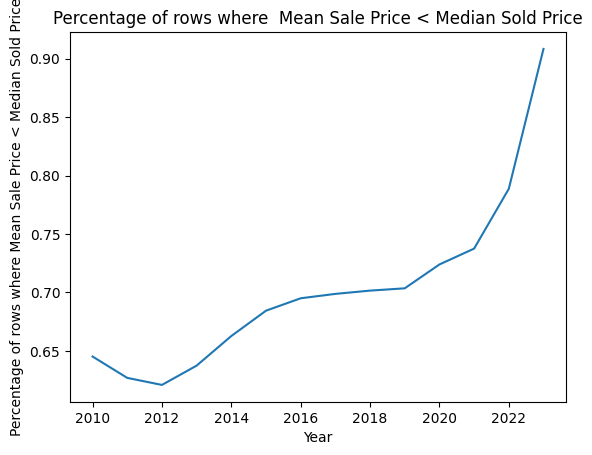

In [18]:
# display number of rows where mean_ price > median_price and show those rows and year is greater than 2015
year = [2010, 2011, 2012, 2013, 2014, 2015, 2016, 2017, 2018, 2019, 2020, 2021, 2022, 2023]
percentages = []
for y in year:
    df_prices_over = df_prices[
        (df_prices['mean_price'] > df_prices['median_price']) &
        (df_prices['year'] > str(y))
    ]
    # display number of rows where mean_ price < median_price and show those rows
    df_prices_under = df_prices[
        (df_prices['mean_price'] < df_prices['median_price']) &
        (df_prices['year'] > str(y))
    ]
    percentages.append(len(df_prices_under)/ len(df_prices_over))
# make a graph of year vs percentage
import matplotlib.pyplot as plt 
plt.plot(year, percentages)
plt.xlabel('Year')
plt.ylabel('Percentage of rows where Mean Sale Price < Median Sold Price')
plt.title('Percentage of rows where  Mean Sale Price < Median Sold Price')
plt.show()

In [4]:
# list all unique values in each column except for 'value'
for col in df.columns:
    if col != 'value':
        unique_vals = df[col].unique()
        print(f"Column: {col}, Unique Values: {unique_vals}")



Column: statistic, Unique Values: ['Volume of Sales' 'Value of Sales' 'Mean Sale Price' 'Median Price']
Column: year, Unique Values: ['2010' '2011' '2012' '2013' '2014' '2015' '2016' '2017' '2018' '2019'
 '2020' '2021' '2022' '2023' '2024']
Column: county, Unique Values: ['Carlow' 'Dublin' 'Kildare' 'Kilkenny' 'Laois' 'Longford' 'Louth' 'Meath'
 'Offaly' 'Westmeath' 'Wexford' 'Wicklow' 'Clare' 'Cork' 'Kerry'
 'Limerick' 'Tipperary' 'Waterford' 'Galway' 'Leitrim' 'Mayo' 'Roscommon'
 'Sligo' 'Cavan' 'Donegal' 'Monaghan']
Column: dwelling_status, Unique Values: ['All Dwelling Statuses' 'New' 'Existing']
Column: stamp_duty_event, Unique Values: ['Filings' 'Executions']
Column: type_of_buyer, Unique Values: ['All Buyer Types' 'Household Buyer - All'
 'Household Buyer - First-Time Buyer Owner-Occupier'
 'Household Buyer - Former Owner-Occupier'
 'Household Buyer - Non-Occupier' 'Non-Household Buyer']
Column: type_of_sale, Unique Values: ['All Sale Types' 'Market' 'Non-Market']


more data cleanup

In [11]:
# Drop unnecessary columns
cols_to_drop = ['stamp_duty_event_type', 'statistic']
df_model = df.drop(columns=cols_to_drop, errors='ignore')

# Handle missing values
df_model = df_model.dropna(subset=['value'])

# Rename columns for readability
df_model.rename(columns={
    'value': 'price',
    'type_of_buyer': 'buyer_type'
}, inplace=True)

# Filter for first-time buyers only
df_model = df_model[df_model['buyer_type'] == 'Household Buyer - First-Time Buyer Owner-Occupier']

# Encode categorical columns
df_model = pd.get_dummies(df_model, columns=['county', 'dwelling_status'], drop_first=True)
df_model.head()


,year,stamp_duty_event,buyer_type,type_of_sale,price,county_Carlow,county_Cavan,county_Clare,county_Cork,county_Donegal,...,county_Offaly,county_Roscommon,county_Sligo,county_Tipperary,county_Waterford,county_Westmeath,county_Wexford,county_Wicklow,dwelling_status_Existing,dwelling_status_New
6,2010,Filings,Household Buyer - First-Time Buyer Owner-Occupier,All Sale Types,12157.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
7,2010,Filings,Household Buyer - First-Time Buyer Owner-Occupier,Market,10434.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
8,2010,Filings,Household Buyer - First-Time Buyer Owner-Occupier,Non-Market,1723.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
24,2010,Executions,Household Buyer - First-Time Buyer Owner-Occupier,All Sale Types,11268.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
25,2010,Executions,Household Buyer - First-Time Buyer Owner-Occupier,Market,9691.0,False,False,False,False,False,...,False,False,False,False,False,False,False,False,False,False
